In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
class FLD:
    def __init__(self, num_labels):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.mean_vectors = None
        self.sw = None
        self.sb = None
        self.w = None
        self.slope = None
        self.num_labels = num_labels

    def fit(self, X, y):
        x_list = []
        x_mean = []
        for i in range(self.num_labels):
            xi = X[y == i]
            x_list.append(xi)
            x_mean.append(np.mean(xi, axis=0))
        self.mean_vectors = x_mean
        
        # calculate Sw
        num_features = X.shape[1]
        self.sw = np.zeros((num_features, num_features))
        for i in range(self.num_labels):
            self.sw += np.matmul((x_list[i] - x_mean[i]).T, (x_list[i] - x_mean[i]))
        
        # calculate Sb
        m = np.mean(X, axis=0)
        self.sb = np.zeros((num_features, num_features))
        for i in range(self.num_labels):
            Nk = x_list[i].shape[0]
            tmp = (x_mean[i] - m).reshape(num_features,1)
            self.sb += Nk * np.matmul(tmp, tmp.T)
            
        sw_inv = np.linalg.inv(self.sw)
        eigenvalue, eigenvector = np.linalg.eig(np.matmul(sw_inv, self.sb))

        # set w to eigenvector that correspons to the largest eigenvalue
        max_eigenvalue_idx = np.argmax(eigenvalue)
        self.w = eigenvector[:, max_eigenvalue_idx]
        self.w = (self.w).reshape(num_features,1)

    def predict_using_class_mean(self, X, y, X_test):
        # return y_pred
        X_proj = np.matmul(X, self.w)
        X_test_proj = np.matmul(X_test, self.w)
        y_pred = []
        x_means = []
        for i in range(self.num_labels):
            x_means.append(np.mean(X_proj[y==i]))
        x_means = np.array(x_means)
        for i in range(X_test_proj.shape[0]):
            dis = np.abs(x_means - X_test_proj[i, 0])
            idx = np.argmin(dis)
            y_pred.append(idx)
            
        return y_pred
        

    def predict_using_knn(self, X, y, X_test, k=1):
        # return y_pred
        X_proj = np.matmul(X, self.w)
        X_test_proj = np.matmul(X_test, self.w)
        y_pred = []
        
        for i in range(X_test_proj.shape[0]):
            dis = np.abs(X_proj - X_test_proj[i, 0])
            dis = dis.squeeze()
            idxs = dis.argsort()[:k]
            # voting for results
            cnt = [0] * self.num_labels
            for j in range(k):
                cnt[y[idxs[j]]] += 1
            y_pred.append(np.argmax(cnt))
        
        return y_pred
        

    def show_confusion_matrix(self, y, y_pred):
        con_mat = np.zeros((self.num_labels, self.num_labels), dtype=int)
        for i in range(self.num_labels):
            for j in range(self.num_labels):
                cnt = 0
                for idx in range(len(y)):
                    if y[idx]==i and y_pred[idx]==j:
                        cnt += 1
                
                con_mat[i][j] = cnt
        
        print(con_mat)
        

    def plot_projection(self, X, y):
        # Only support 2-d 3-label problem
        
        self.slope = self.w[1][0] / self.w[0][0]
        x_lin = np.linspace(-13, 8, 50)
        y_lin = x_lin * self.slope

        plt.plot(x_lin, y_lin)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Projection Line: w={self.slope}, b=0')

        # plot class1 training data
        x_c1, y_c1 = X[y == 0][:, 0], X[y == 0][:, 1]
        plt.scatter(x_c1, y_c1, color='red', s=12, label='class1')

        # plot class2 training data
        x_c2, y_c2 = X[y == 1][:, 0], X[y == 1][:, 1]
        plt.scatter(x_c2, y_c2, color='blue', s=12, label='class2')
        
        # plot class3 training data
        x_c3, y_c3 = X[y == 2][:, 0], X[y == 2][:, 1]
        plt.scatter(x_c3, y_c3, color='green', s=12, label='class3')

        # project training data
        w = np.squeeze(self.w)
        for i in range(len(X)):
            projection = (np.dot(X[i], w) / np.dot(w, w)) * w
            if y[i] == 0:
                plt.scatter(projection[0], projection[1], s=10, color='red')
                plt.plot([X[i][0], projection[0]], [X[i][1], projection[1]], c='red', alpha=0.05)
            elif y[i] == 1:
                plt.scatter(projection[0], projection[1], s=10, color='blue')
                plt.plot([X[i][0], projection[0]], [X[i][1], projection[1]], c='blue', alpha=0.05)
            else:
                plt.scatter(projection[0], projection[1], s=10, color='green')
                plt.plot([X[i][0], projection[0]], [X[i][1], projection[1]], c='green', alpha=0.05)

    def accuracy_score(self, y, y_pred):
        acc = (y == y_pred).sum() / len(y)
        return acc
        

In [3]:
class MultiClassLogisticRegression:
    
    def __init__(self, num_labels):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.epoch = []
        self.train_loss = []
        self.weights = None
        self.num_labels = num_labels

    def fit(self, X, y, batch_size=16, lr=0.001, epoch=100):
        # y to one-hot
        y_onehot = np.eye(self.num_labels)[y]
        num_features = X.shape[1]
        self.weights = np.zeros((num_features, self.num_labels))
        
        for i in range(epoch):
            x_dot = np.matmul(X, self.weights)
            x_softmax = np.array([self.softmax(x_dot[i]) for i in range(len(X))])
            loss = self.cross_entropy(y_onehot, x_softmax)

            dw = (1 / len(y)) * X.T @ (x_softmax - y_onehot)
            self.weights -= lr * dw
            #print(f'{i}: {loss}')
            self.epoch.append(i)
            self.train_loss.append(loss)

    def predict(self, X):
        x_dot = np.matmul(X, self.weights)
        x_softmax = np.array([self.softmax(x_dot[i]) for i in range(len(X))])
        y_pred = np.argmax(x_softmax, axis=1)
        return y_pred

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        return self.accuracy_score(y, y_pred)

    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z))

    def cross_entropy(self, y, probs):
        # y is one-hot
        return -np.sum(y * np.log(probs)) / len(y)
        
    
    def accuracy_score(self, y, y_pred):
        acc = (y == y_pred).sum() / len(y)
        return acc

    def show_confusion_matrix(self, X, y):
        y_pred = self.predict(X)
        con_mat = np.zeros((self.num_labels, self.num_labels), dtype=int)
        for i in range(self.num_labels):
            for j in range(self.num_labels):
                cnt = 0
                for idx in range(len(y)):
                    if y[idx]==i and y_pred[idx]==j:
                        cnt += 1
                
                con_mat[i][j] = cnt
        
        print(con_mat)
    
    def plot_curve(self):
        plt.plot(self.epoch, self.train_loss, 'b')
        plt.xlabel('epoch', fontsize=12)
        plt.ylabel('loss', fontsize=12)
        plt.show()

# Prepare data for Q1 ~ Q12

In [4]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_blob_train.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_blob_test.csv"))

In [5]:
X_train = df_train[['Feature1', 'Feature2']].to_numpy()
y_train = df_train[['Target']].to_numpy().ravel()

X_test = df_test[['Feature1', 'Feature2']].to_numpy()
y_test = df_test[['Target']].to_numpy().ravel()

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test",  X_test.shape)
print("y_test",  y_test.shape)

X_train (1000, 2)
y_train (1000,)
X_test (1000, 2)
y_test (1000,)


In [6]:
# Only these three packages are allowed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# MultiClass Logistic Regression

In [7]:
# For Q1
lr = 0.001
batch_size = len(X_train)
epoch = 2500

logistic_reg = MultiClassLogisticRegression(3)
logistic_reg.fit(X_train, y_train, lr=lr, batch_size=batch_size, epoch=epoch)

In [8]:
# For Q2
print('Training acc: ', logistic_reg.evaluate(X_train, y_train))

Training acc:  0.894


In [9]:
# For Q3
print('Testing acc: ', logistic_reg.evaluate(X_test, y_test))

Testing acc:  0.884


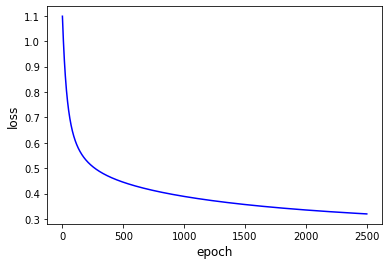

In [10]:
# For Q4
logistic_reg.plot_curve()

In [11]:
# For Q5
logistic_reg.show_confusion_matrix(X_test, y_test)

[[281   0  59]
 [  0 333   0]
 [ 57   0 270]]


# Fisher's Linear Discriminant Analysis

In [12]:
fld = FLD(3)

fld.fit(X_train, y_train)

In [13]:
# For Q6
print("Class mean vector: ", fld.mean_vectors)

Class mean vector:  [array([-4.17505764,  6.35526804]), array([-9.43385176, -4.87830741]), array([-2.54454008,  7.53144179])]


In [14]:
# For Q7
print("Within-class scatter matrix SW: ", fld.sw)

Within-class scatter matrix SW:  [[1052.70745046  -12.5828441 ]
 [ -12.5828441   971.29686189]]


In [15]:
# For Q8
print("Between-class scatter matrix SB: ", fld.sb)

Between-class scatter matrix SB:  [[ 8689.12907035 16344.86572983]
 [16344.86572983 31372.93949414]]


In [16]:
# For Q9
print("W: ", fld.w)

W:  [[-0.44115384]
 [-0.8974315 ]]


In [17]:
# For Q10
y_pred = fld.predict_using_class_mean(X_train, y_train, X_test)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_test, y_pred))

fld.show_confusion_matrix(y_test, y_pred)

FLD using class mean, accuracy:  0.861
[[262   0  78]
 [  0 333   0]
 [ 61   0 266]]


In [18]:
# For Q11
y_pred_k1 = fld.predict_using_knn(X_train, y_train, X_test, k=1)
print("FLD using knn (k=1), accuracy: ", fld.accuracy_score(y_test, y_pred_k1))

y_pred_k2 = fld.predict_using_knn(X_train, y_train, X_test, k=2)
print("FLD using knn (k=2), accuracy: ", fld.accuracy_score(y_test, y_pred_k2))

y_pred_k3 = fld.predict_using_knn(X_train, y_train, X_test, k=3)
print("FLD using knn (k=3), accuracy: ", fld.accuracy_score(y_test, y_pred_k3))

y_pred_k4 = fld.predict_using_knn(X_train, y_train, X_test, k=4)
print("FLD using knn (k=4), accuracy: ", fld.accuracy_score(y_test, y_pred_k4))

y_pred_k5 = fld.predict_using_knn(X_train, y_train, X_test, k=5)
print("FLD using knn (k=5), accuracy: ", fld.accuracy_score(y_test, y_pred_k5))

FLD using knn (k=1), accuracy:  0.822
FLD using knn (k=2), accuracy:  0.819
FLD using knn (k=3), accuracy:  0.843
FLD using knn (k=4), accuracy:  0.84
FLD using knn (k=5), accuracy:  0.862


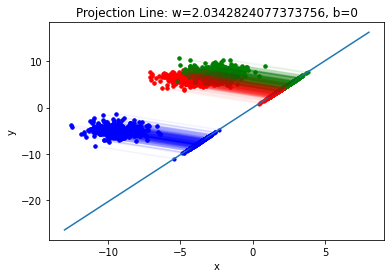

In [19]:
# For Q12, using only training data
fld.plot_projection(X_train, y_train)

# Train your own model on provided dataset.
You can only using 1) **Fisher's Linear Discriminant** or 2) **Logistic Regression** that you have implemented above.

In [20]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW2_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))

In [21]:
df_train.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00668,0.00192,0.682,0.996,2.0
1,0.00680,0.00106,0.503,0.996,1.0
2,0.00742,0.00106,0.482,0.991,1.0
3,0.00685,0.00178,0.650,0.998,2.0
4,0.00680,0.00163,0.623,0.996,2.0


In [22]:
df_test.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00699,0.000877,0.451,0.994,NaN
1,0.00736,0.001370,0.549,0.998,NaN
2,0.00687,0.001420,0.580,0.992,NaN
3,0.00752,0.002520,0.737,0.996,NaN
4,0.00685,0.000910,0.464,0.992,NaN


In [23]:
# Data processing
# Refer to section "Prepare data for Q1 ~ Q12"

x_train = df_train.drop(['Target'], axis=1)
#x_train = df_train.drop(['Target', 'Feature3'], axis=1)
y_train = df_train['Target']
x_train = np.array(x_train)
y_train = np.array(y_train, dtype=int)
print(x_train.shape)

x_val = df_val.drop(['Target'], axis=1)
#x_val = df_val.drop(['Target', 'Feature3'], axis=1)
y_val = df_val['Target']
x_val = np.array(x_val)
y_val = np.array(y_val, dtype=int)
print(x_val.shape)

x_test = df_test.drop(['Target'], axis=1)
x_test = np.array(x_test)
print(x_test.shape)

class QuantileTransformer:
    def __init__(self, n_quantiles=100):
        self.n_quantiles = n_quantiles

    def fit(self, X):
        self.quantiles_ = np.linspace(0, 1, self.n_quantiles)
        self.references_ = np.quantile(X, self.quantiles_)
        return self

    def transform(self, X):
        X_transformed = np.interp(X, self.references_, self.quantiles_)
        return X_transformed

    def fit_transform(self, X):
        return self.fit(X).transform(X)

def l2_norm(x):
    return x / np.sqrt(np.sum(x * x))


x_train = np.array([l2_norm(x_train[i]) for i in range(len(x_train))])
x_val = np.array([l2_norm(x_val[i]) for i in range(len(x_val))])
x_test = np.array([l2_norm(x_test[i]) for i in range(len(x_test))])

quantile_transformer = QuantileTransformer(500)
x_train = quantile_transformer.fit_transform(x_train)
x_val = quantile_transformer.transform(x_val)
x_test = quantile_transformer.transform(x_test)

(1703, 4)
(730, 4)
(5677, 4)


In [24]:
# Train your model here

# your_model = ...

# Try FLD
my_fld = FLD(3)
my_fld.fit(x_train, y_train)

y_pred = my_fld.predict_using_class_mean(x_train, y_train, x_val)
print("FLD using class mean, accuracy: ", my_fld.accuracy_score(y_val, y_pred))

y_pred_k1 = my_fld.predict_using_knn(x_train, y_train, x_val, k=1)
print("FLD using knn (k=1), accuracy: ", my_fld.accuracy_score(y_val, y_pred_k1))

y_pred_k2 = my_fld.predict_using_knn(x_train, y_train, x_val, k=2)
print("FLD using knn (k=2), accuracy: ", my_fld.accuracy_score(y_val, y_pred_k2))

y_pred_k3 = my_fld.predict_using_knn(x_train, y_train, x_val, k=3)
print("FLD using knn (k=3), accuracy: ", my_fld.accuracy_score(y_val, y_pred_k3))

y_pred_k4 = my_fld.predict_using_knn(x_train, y_train, x_val, k=4)
print("FLD using knn (k=4), accuracy: ", my_fld.accuracy_score(y_val, y_pred_k4))

y_pred_k5 = my_fld.predict_using_knn(x_train, y_train, x_val, k=5)
print("FLD using knn (k=5), accuracy: ", my_fld.accuracy_score(y_val, y_pred_k5))

y_pred_k10 = my_fld.predict_using_knn(x_train, y_train, x_val, k=10)
print("FLD using knn (k=10), accuracy: ", my_fld.accuracy_score(y_val, y_pred_k10))

y_pred_k20 = my_fld.predict_using_knn(x_train, y_train, x_val, k=20)
print("FLD using knn (k=20), accuracy: ", my_fld.accuracy_score(y_val, y_pred_k20))

y_pred_k30 = my_fld.predict_using_knn(x_train, y_train, x_val, k=30)
print("FLD using knn (k=30), accuracy: ", my_fld.accuracy_score(y_val, y_pred_k30))

y_pred_k40 = my_fld.predict_using_knn(x_train, y_train, x_val, k=40)
print("FLD using knn (k=40), accuracy: ", my_fld.accuracy_score(y_val, y_pred_k40))

y_pred_k50 = my_fld.predict_using_knn(x_train, y_train, x_val, k=50)
print("FLD using knn (k=50), accuracy: ", my_fld.accuracy_score(y_val, y_pred_k50))

FLD using class mean, accuracy:  0.8780821917808219
FLD using knn (k=1), accuracy:  0.8438356164383561
FLD using knn (k=2), accuracy:  0.8493150684931506
FLD using knn (k=3), accuracy:  0.873972602739726
FLD using knn (k=4), accuracy:  0.8780821917808219
FLD using knn (k=5), accuracy:  0.8794520547945206
FLD using knn (k=10), accuracy:  0.8808219178082192
FLD using knn (k=20), accuracy:  0.8890410958904109
FLD using knn (k=30), accuracy:  0.8945205479452055
FLD using knn (k=40), accuracy:  0.9054794520547945
FLD using knn (k=50), accuracy:  0.9041095890410958


In [25]:
test_pred = my_fld.predict_using_knn(x_train, y_train, x_test, k=50)
test_pred = np.expand_dims(test_pred, axis=1)
print("test_pred shape: ", test_pred.shape)

test_pred shape:  (5677, 1)


# Output the csv file

In [26]:
# For Q13
df_test = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("sample_output.csv")